<center>
<p style="font-size:3em; text-align:center">QWZ model dirty edge local density </p>
<img src="QWZBHZ.png" alt="drawing" width="300"/>

<p style="font-size:1.3em;"><img src="QWZ.svg" alt="drawing" style="float: left; width:600px; margin-right:50px;">
In this notebook, I am going to examine the properties of the QWZ model, focusing on the local density of states and the appearance of edge states. The main performed tasks in the notebook are the construction of an infinity QWZ ribbon and a finite bulk sample, adding a scatterer part to the sample, then merging the semi-infinite wires to the sample and calculating the local density of states. The qwz.py file contains my code, which simulates the system and calculates the energy-dependent quantities. I tried to comment on it in a way that may be understandable in itself. In the QWZ model, the connection of the lattice sites is described by 2 times 2 matrices, according to the figure.
</p>

</br> </br> 
<p style="font-size:2em; text-align:left"> QWZ model ribbon </p>

In [15]:
#%matplotlib widget
from QWZ import *

To calculate the Greens of the semi-infinite ribbons, one had to determine the $H_0$ and $H_1$. An elementary cell will be on a row of the wire, that contains $L$ sites. The corresponding Hamiltonian operator can be constructed according to the next code cell.

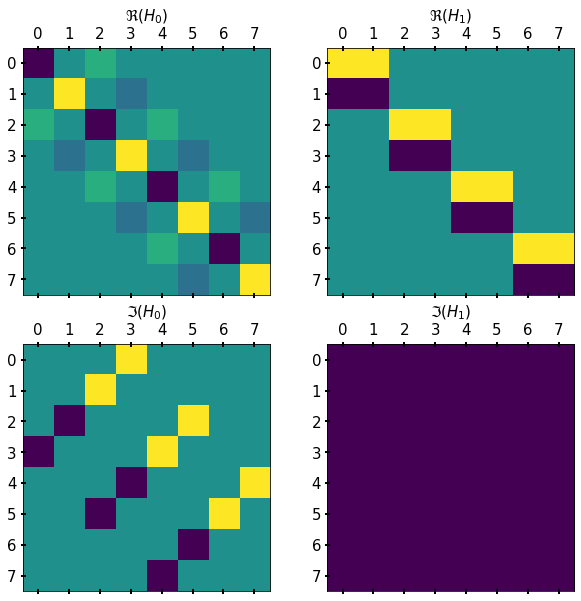

In [2]:
#Pauli matrices
sigma_0 = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])
                   
#The onsite and hopping terms
U = -2 * sigma_z
T_x = 0.5 * (sigma_z + 1j*sigma_x)
T_y = 0.5 * (sigma_z + 1j*sigma_y)
          
L = 4
    
#onsite energy
Hu = np.kron(np.eye(L), U)

#Unit cell
h0 = np.eye(L, k=1) #each site connects to its neighbours
H0 = np.matrix(np.kron(h0, T_x)) #add the inside degrees of freedom
H0 = Hu + H0 + H0.H

#relations between unit cells
h1 = np.eye(L)
H1 = np.matrix(np.kron(h1, T_y))


#plot the matrix
fig, axes = plt.subplots(2,2, figsize=(10,10))

ax = axes[0][0]
ax.set_title('$\Re(H_0)$', fontsize=15)
ax.matshow(np.real(H0))
ax.tick_params(size=5, width=2, direction='inout', labelsize=15)

ax = axes[1][0]
ax.set_title('$\Im(H_0)$', fontsize=15)
ax.matshow(np.imag(H0))
ax.tick_params(size=5, width=2, direction='inout', labelsize=15)

ax = axes[0][1]
ax.set_title('$\Re(H_1)$', fontsize=15)
ax.matshow(np.real(H1))
ax.tick_params(size=5, width=2, direction='inout', labelsize=15)

ax = axes[1][1]
ax.set_title('$\Im(H_1)$', fontsize=15)
ax.matshow(np.imag(H1))
ax.tick_params(size=5, width=2, direction='inout', labelsize=15)

plt.show()

One can calculate the spectrum of the ribbon as a function of the wavenumber. In the following figure, the delta parameter and the width of the ribbon are tunable.

In [3]:
display(I1)

interactive(children=(IntSlider(value=5, continuous_update=False, description='$L$', max=20, min=5, step=5), F…

I calculated the Green's function of the two half of the wire based on the mezo.py file. This is done by the leads_Green method of my class.

In [13]:
QWZ = dirty_edge_QWZ_model(10,-1)
QWZ.create_lead()
QWZ.leads_Green(0)

</br> </br> 
<p style="font-size:2em; text-align:left"> QWZ model finite sample </p>

For simplicity, I construct the sample as a finite part of the wire.

In [55]:
W = 4
H = np.kron(np.eye(W), H0) + np.kron(np.eye(W,k=1), H1) + np.kron(np.eye(W,k=-1), H1.H)

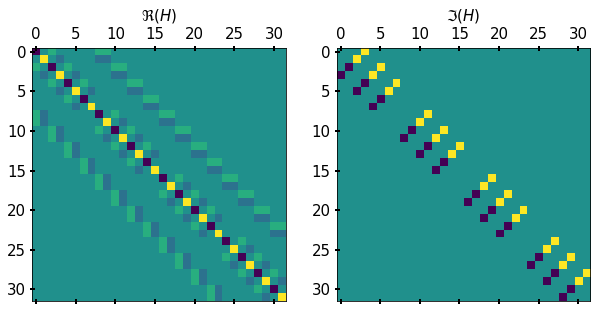

In [59]:
#plot the matrix
fig, axes = plt.subplots(1,2, figsize=(10,5))

ax = axes[0]
ax.set_title('$\Re(H)$', fontsize=15)
ax.matshow(np.real(H))
ax.tick_params(size=5, width=2, direction='inout', labelsize=15)

ax = axes[1]
ax.set_title('$\Im(H)$', fontsize=15)
ax.matshow(np.imag(H))
ax.tick_params(size=5, width=2, direction='inout', labelsize=15)

plt.show()

The next step is adding the scattering part to the sample. I implemented two different approaches, first I  simply cut out the a part from the Hamiltonian, i.e. I replaced the corresponding elements by zeros. The second approach is adding a random unitary matrix to the scattering part of the Hamiltonian $\left(H' = H + \alpha V\right)$.
I used matplotlib.path.Path object to select the scatterer part of the operator.

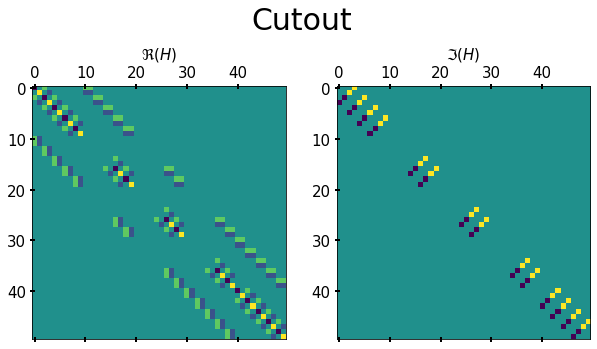

In [39]:
QWZ = dirty_edge_QWZ_model(5,-1) #create QWZ model object
QWZ.create_lead()  #create the lead
QWZ.create_hamiltonian(5, V_size=3, V_pos=(1,0), cut=True) # create the Sample part and cutout a part

#plot the Hamiltonian
H = QWZ.H_S

fig, axes = plt.subplots(1,2, figsize=(10,6))
fig.suptitle('Cutout', fontsize=30)

ax = axes[0]
ax.set_title('$\Re(H)$', fontsize=15)
ax.matshow(np.real(H))
ax.tick_params(size=5, width=2, direction='inout', labelsize=15)

ax = axes[1]
ax.set_title('$\Im(H)$', fontsize=15)
ax.matshow(np.imag(H))
ax.tick_params(size=5, width=2, direction='inout', labelsize=15)

plt.show()

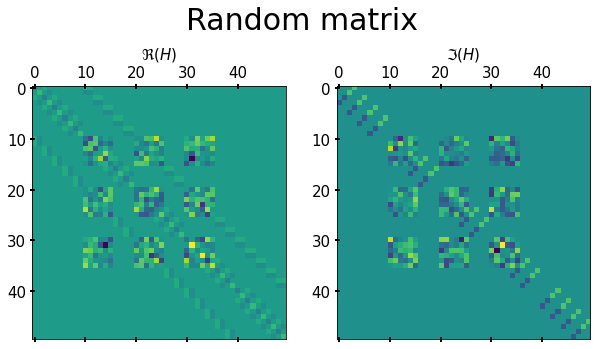

In [40]:
QWZ = dirty_edge_QWZ_model(5,-1) #create QWZ model object
QWZ.create_lead()  #create the lead
QWZ.create_hamiltonian(5, alpha=1, V_size=3, V_pos=(1,0), random=True) # create the Sample part and add a random matrix

#plot the Hamiltonian
H = QWZ.H_S

fig, axes = plt.subplots(1,2, figsize=(10,6))
fig.suptitle('Random matrix', fontsize=30)

ax = axes[0]
ax.set_title('$\Re(H)$', fontsize=15)
ax.matshow(np.real(H))
ax.tick_params(size=5, width=2, direction='inout', labelsize=15)

ax = axes[1]
ax.set_title('$\Im(H)$', fontsize=15)
ax.matshow(np.imag(H))
ax.tick_params(size=5, width=2, direction='inout', labelsize=15)

plt.show()

I calculated the spectrum of the hamiltonian and density of the particle density. The red sites belong to the scatterer.

In [16]:
display(I2)

interactive(children=(IntSlider(value=401, continuous_update=False, description='n', max=799, min=1), FloatSli…

The next step is the calculation of the Green's function of the system from the Green's function of the decoupled Green's functions via the Dyson equation. The following interactive plots make it possible to study the effect of the tuning of the parameters. These parameters are the size and the position of the dirt, the value of the onsite energy in the system and in the random matrix case the relative strength of the scattering operator (the value of $\alpha$). 

* Tune the parameter $\Delta$ and energy

In this case, I added a square scatterer to the left side of the wire. $(L=20, W=20)$

In [4]:
display(I3)

interactive(children=(FloatSlider(value=-0.5, continuous_update=False, description='E', max=4.0, min=-4.0, ste…

 * tune the size and the position along the y axis
 
In this case $E=-0.5$ and $\Delta=-1$ $(L=20, W=20)$

In [6]:
display(I4)

interactive(children=(IntSlider(value=8, continuous_update=False, description='$y$', max=20), IntSlider(value=…

 * tune the $\alpha$ parameter
 
In that case $E=-0.5$, $\Delta=-1$ $(L=20, W=20)$

In [6]:
display(I5)

interactive(children=(IntSlider(value=49, continuous_update=False, description='$\\alpha$'), Output(outputs=({…

Based on the result, we can state that at proper energies around zero, the value of the local density of states is higher on the edges of the system (edge states). If there is dirt on the edge of the wire, this property does not change. In the QWZ model, the appearance of edge states is robust against the random perturbation of the Hamilton operator. By tuning the delta parameter in the topological interval, we found the same behaviour, but by approaching the -2 the effect is less noticeable.

If we decrease the number of the sites (W and L) then the result remains the same. At the proper energies, the local density of states is non-zero at the edge of the wire and around dirt.

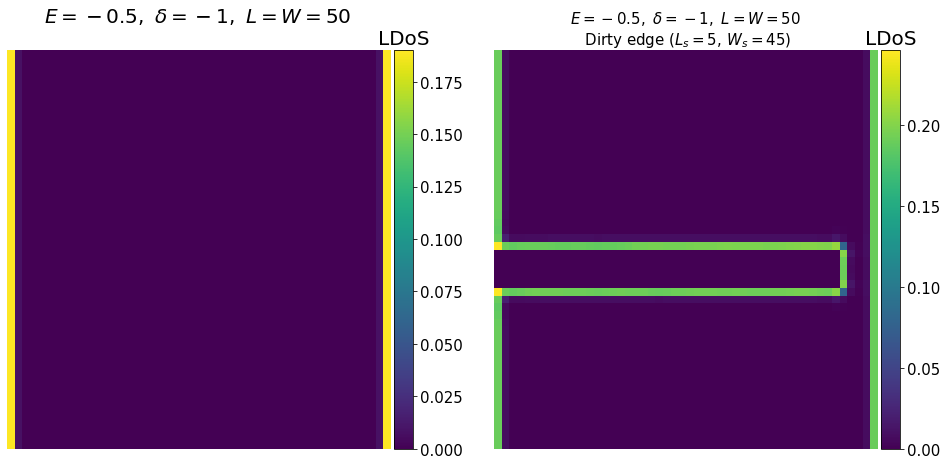

In [14]:
QWZ = dirty_edge_QWZ_model(L = 50, delta = -1)
ldos = QWZ.LDOS(-0.6, alpha=100, V_size = 0)


fig,axes = plt.subplots(1, 2, figsize=(2*8, 8*((QWZ.W+2)/QWZ.L)))

ax = axes[0]
ax.set_title("$E=-0.5, \, \, \delta=-1, \, \, L = W = 50 $ \n ", fontsize=20)
im = ax.imshow(ldos, origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad = 0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.set_title('LDoS', fontsize = 20)
cbar.ax.tick_params(labelsize = 15) 
ax.axis('off')

QWZ = dirty_edge_QWZ_model(L = 50, delta = -1)
ldos = QWZ.LDOS(-0.6, alpha=100, V_size = (45,5), V_pos = (20,0))
ldos[1:-1,:][QWZ.lattice_index.reshape((QWZ.L, QWZ.L))]=0


ax = axes[1]
ax.set_title("$E=-0.5, \, \, \delta=-1, \, \, L = W = 50$ \n Dirty edge $(L_s=5, \, W_s=45)$", fontsize=15)
im = ax.imshow(ldos, origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad = 0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.set_title('LDoS', fontsize = 20)
cbar.ax.tick_params(labelsize = 15) 
ax.axis('off')


plt.show()
